## Problem Statement
You are working for a new-age insurance company and employ mutiple outreach plans to sell term insurance to your customers. Telephonic marketing campaigns still remain one of the most effective way to reach out to people however they incur a lot of cost. Hence, it is important to identify the customers that are most likely to convert beforehand so that they can be specifically targeted via call. We are given the historical marketing data of the insurance company and are required to build a ML model that will predict if a client will subscribe to the insurance.

## Features: 
age (numeric)<br>
job : type of job<br>
marital : marital status<br>
educational_qual : education status<br>
call_type : contact communication type<br>
day: last contact day of the month (numeric)<br>
mon: last contact month of year<br>
dur: last contact duration, in seconds (numeric)<br>
num_calls: number of contacts performed during this campaign and for this client <br>
prev_outcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")<br>

#### Output variable (desired target):<br>
y - has the client subscribed to the insurance?


## Imports

In [1]:
# Data manipution and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Cross Validation
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

# Evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, RocCurveDisplay, classification_report

## Import the Dataset

In [2]:
df = pd.read_csv(r'D:\Data Science\Guvi\Final Project\dataset\train (2).csv')

In [3]:
df

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
0,58,management,married,tertiary,unknown,5,may,261,1,unknown,no
1,44,technician,single,secondary,unknown,5,may,151,1,unknown,no
2,33,entrepreneur,married,secondary,unknown,5,may,76,1,unknown,no
3,47,blue-collar,married,unknown,unknown,5,may,92,1,unknown,no
4,33,unknown,single,unknown,unknown,5,may,198,1,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,cellular,17,nov,977,3,unknown,yes
45207,71,retired,divorced,primary,cellular,17,nov,456,2,unknown,yes
45208,72,retired,married,secondary,cellular,17,nov,1127,5,success,yes
45209,57,blue-collar,married,secondary,telephone,17,nov,508,4,unknown,no


In [4]:
df.shape

(45211, 11)

In [5]:
df.describe()

,age,day,dur,num_calls
count,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,15.806419,258.163080,2.763841
std,10.618762,8.322476,257.527812,3.098021
min,18.000000,1.000000,0.000000,1.000000
25%,33.000000,8.000000,103.000000,1.000000
50%,39.000000,16.000000,180.000000,2.000000
75%,48.000000,21.000000,319.000000,3.000000
max,95.000000,31.000000,4918.000000,63.000000


In [6]:
df['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [7]:
print('Not Subscribed - ', round(df['y'].value_counts()['no']/len(df)*100, 2), '% of the dataset')
print('Subscribed - ', round(df['y'].value_counts()['yes']/len(df)*100, 2), '% of the dataset')

Not Subscribed -  88.3 % of the dataset
Subscribed -  11.7 % of the dataset


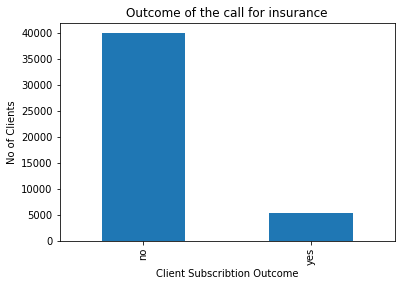

In [8]:
df['y'].value_counts().plot(kind='bar')
plt.title('Outcome of the call for insurance')
plt.xlabel('Client Subscribtion Outcome')
plt.ylabel('No of Clients')
plt.show()

We can see that the data is imbalanced, and resampling have to be used to train a model.

## Data Cleaning

In [9]:
# checking for null values
df.isnull().sum()

age               0
job               0
marital           0
education_qual    0
call_type         0
day               0
mon               0
dur               0
num_calls         0
prev_outcome      0
y                 0
dtype: int64

No null values in the data, but we can see there are 'unknown' category which we consider as null values.

In [10]:
df[df=='unknown'].count()

age                   0
job                 288
marital               0
education_qual     1857
call_type         13020
day                   0
mon                   0
dur                   0
num_calls             0
prev_outcome      36959
y                     0
dtype: int64

In [11]:
# Dropping the duplicate values
df.drop_duplicates(inplace=True)

In [12]:
df.shape

(45205, 11)

In [13]:
# Checking if all the columns are in right format
df.dtypes

age                int64
job               object
marital           object
education_qual    object
call_type         object
day                int64
mon               object
dur                int64
num_calls          int64
prev_outcome      object
y                 object
dtype: object

All Columns are in right format

### age Column

In [14]:
df['age'].unique()

array([58, 44, 33, 47, 35, 28, 42, 43, 41, 29, 53, 57, 51, 45, 60, 56, 32,
       25, 40, 39, 52, 46, 36, 49, 59, 37, 50, 54, 55, 48, 24, 38, 31, 30,
       27, 34, 23, 26, 61, 22, 21, 20, 66, 62, 83, 75, 67, 70, 65, 68, 64,
       69, 72, 71, 19, 76, 85, 63, 90, 82, 73, 74, 78, 80, 94, 79, 77, 86,
       95, 81, 18, 89, 84, 87, 92, 93, 88], dtype=int64)

### job Column

In [15]:
df['job'].unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'unknown', 'retired', 'admin.', 'services', 'self-employed',
       'unemployed', 'housemaid', 'student'], dtype=object)

In [16]:
# Count of unknown values
job_uc = df['job'][df['job']=='unknown'].count()
job_uc

288

In [17]:
job_ucp = (job_uc/len(df['job']))*100
print(f'{round(job_ucp, 2)}% of job column is unknown')

0.64% of job column is unknown


In [18]:
# Imputing job column
df['job'].replace('unknown', df['job'].mode()[0], inplace=True)

In [19]:
df['job'].unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'retired', 'admin.', 'services', 'self-employed', 'unemployed',
       'housemaid', 'student'], dtype=object)

### marital Column

In [20]:
df.marital.unique()

array(['married', 'single', 'divorced'], dtype=object)

### educatioin_qual Column

In [21]:
df.education_qual.unique()

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

In [22]:
eq_uc = df['education_qual'][df['education_qual']=='unknown'].count()
eq_uc

1857

In [23]:
eq_ucp = eq_uc/len(df['education_qual'])*100
print(f'{round(eq_ucp, 2)}% of education_qual column is unknown')

4.11% of education_qual column is unknown


In [24]:
# Imputing education_qual Column
df['education_qual'].replace('unknown', df['education_qual'].mode()[0], inplace=True)

In [25]:
df['education_qual'].unique()

array(['tertiary', 'secondary', 'primary'], dtype=object)

### call_type Column

In [26]:
df.call_type.unique()

array(['unknown', 'cellular', 'telephone'], dtype=object)

In [27]:
ct_uc = df['call_type'][df['call_type']=='unknown'].count()
ct_uc

13017

In [28]:
ct_ucp = ct_uc/len(df['call_type'])*100
print(f'{round(ct_ucp, 2)}% of unknown in call_type column')

28.8% of unknown in call_type column


In [29]:
df['call_type'].value_counts()

cellular     29282
unknown      13017
telephone     2906
Name: call_type, dtype: int64

In [30]:
# call_type Column imputaion
df['call_type'].replace('unknown', df['call_type'].mode()[0], inplace=True)

In [31]:
df['call_type'].unique()

array(['cellular', 'telephone'], dtype=object)

### day Column

In [32]:
df['day'].unique()

array([ 5,  6,  7,  8,  9, 12, 13, 14, 15, 16, 19, 20, 21, 23, 26, 27, 28,
       29, 30,  2,  3,  4, 11, 17, 18, 24, 25,  1, 10, 22, 31],
      dtype=int64)

### mon Column

In [33]:
df['mon'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

### dur Column

In [34]:
df['dur'].unique()

array([ 261,  151,   76, ..., 1298, 1246, 1556], dtype=int64)

### num_calls Column

In [35]:
df['num_calls'].unique()

array([ 1,  2,  3,  5,  4,  6,  7,  8,  9, 10, 11, 12, 13, 19, 14, 24, 16,
       32, 18, 22, 15, 17, 25, 21, 43, 51, 63, 41, 26, 28, 55, 50, 38, 23,
       20, 29, 31, 37, 30, 46, 27, 58, 33, 35, 34, 36, 39, 44],
      dtype=int64)

### prev_outcome Column

In [36]:
df['prev_outcome'].unique()

array(['unknown', 'failure', 'other', 'success'], dtype=object)

In [37]:
po_uc = df['prev_outcome'][df['prev_outcome']=='unknown'].count()
po_uc

36953

In [38]:
po_ucp = po_uc/df['prev_outcome'].count()*100
print(f'{po_ucp}% of prev_outcome Column is unknown')

81.74538214799247% of prev_outcome Column is unknown


In [39]:
df['prev_outcome'].value_counts()

unknown    36953
failure     4901
other       1840
success     1511
Name: prev_outcome, dtype: int64

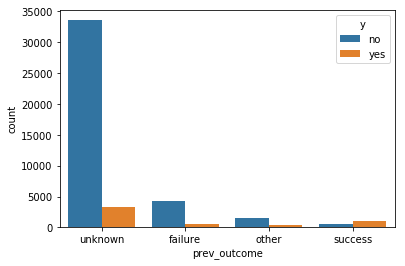

In [40]:
sns.countplot(df['prev_outcome'], hue=df['y'])

80 percent of values are missing in the prev_outcome column and it does not have any meaning to the data if impute. So, the prev_outcome column is better to be dropped.

In [41]:
df.drop('prev_outcome',axis=1, inplace=True)

In [42]:
df.head()

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,y
0,58,management,married,tertiary,cellular,5,may,261,1,no
1,44,technician,single,secondary,cellular,5,may,151,1,no
2,33,entrepreneur,married,secondary,cellular,5,may,76,1,no
3,47,blue-collar,married,secondary,cellular,5,may,92,1,no
4,33,blue-collar,single,secondary,cellular,5,may,198,1,no


## Exploratory Data Analysis

In [43]:
# Putting column names in a list
columns = df.columns.to_list()
print(columns)

# Numerical Columns
num_col = df._get_numeric_data().columns.to_list()
print(num_col)

# Categorical Columns
cat_col = list(set(columns) - set(num_col))
print(cat_col)

['age', 'job', 'marital', 'education_qual', 'call_type', 'day', 'mon', 'dur', 'num_calls', 'y']
['age', 'day', 'dur', 'num_calls']
['education_qual', 'marital', 'call_type', 'mon', 'y', 'job']


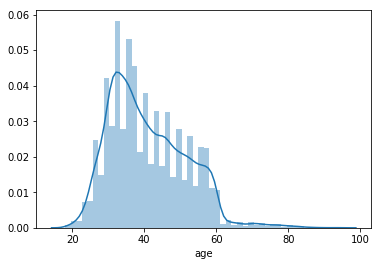

<Figure size 432x288 with 0 Axes>

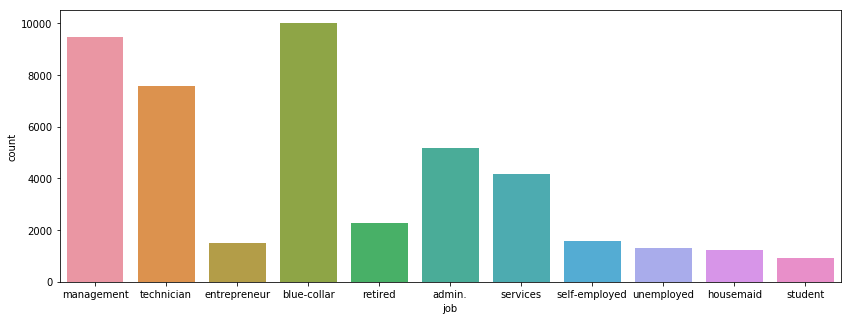

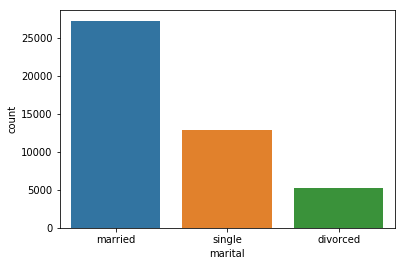

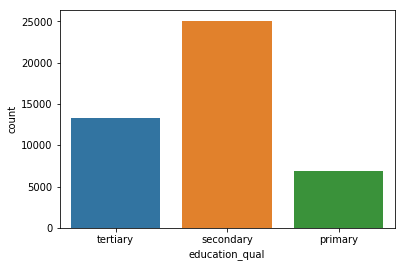

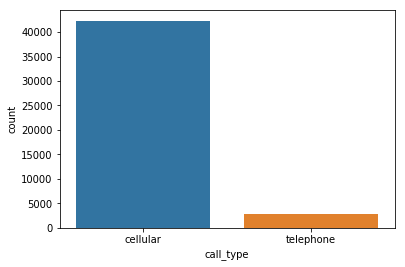

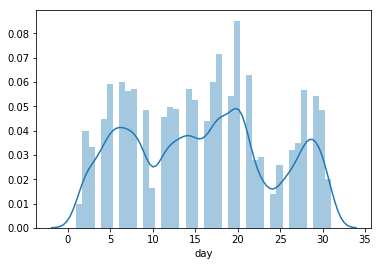

<Figure size 432x288 with 0 Axes>

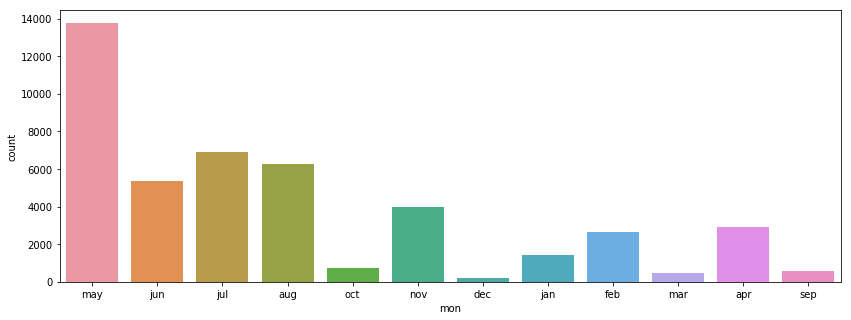

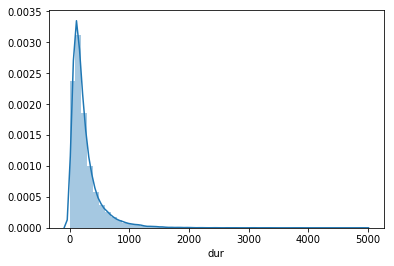

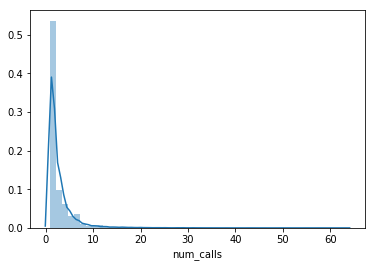

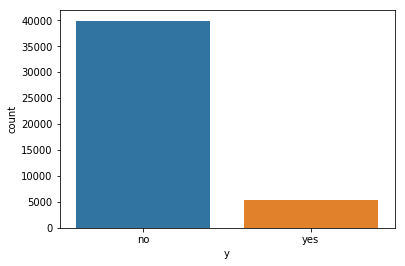

In [44]:
for i in columns:
    plt.figure()
    if i in num_col:
        sns.distplot(df[i])
    else:
        if i=='job' or i=='mon':
            plt.figure(figsize=(14, 5))
        sns.countplot(df[i])

### independant features Vs The Target

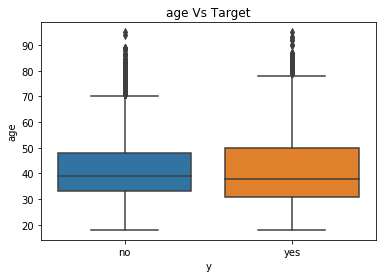

<Figure size 432x288 with 0 Axes>

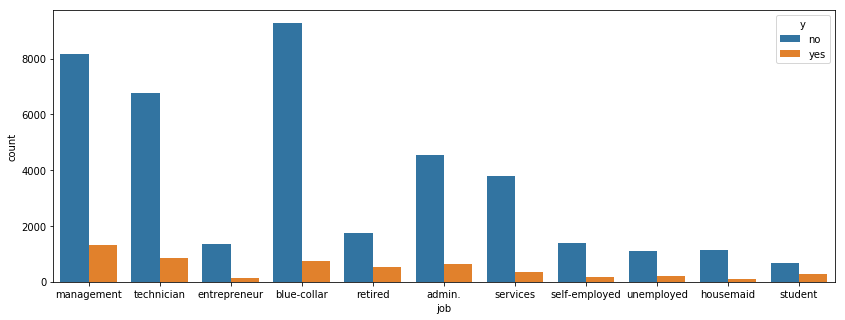

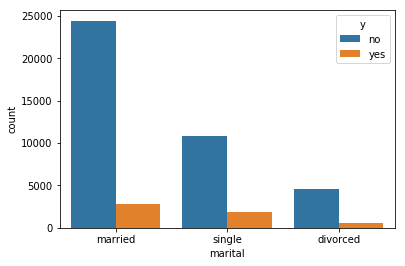

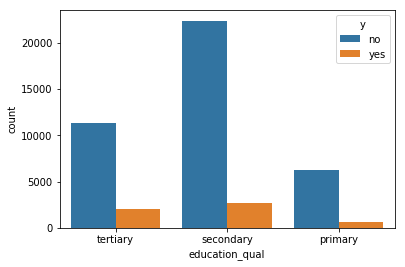

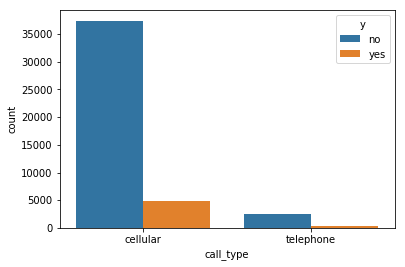

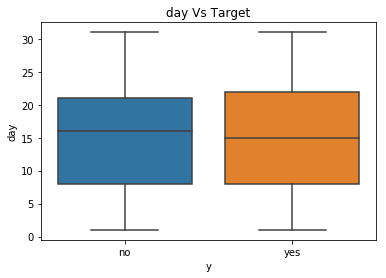

<Figure size 432x288 with 0 Axes>

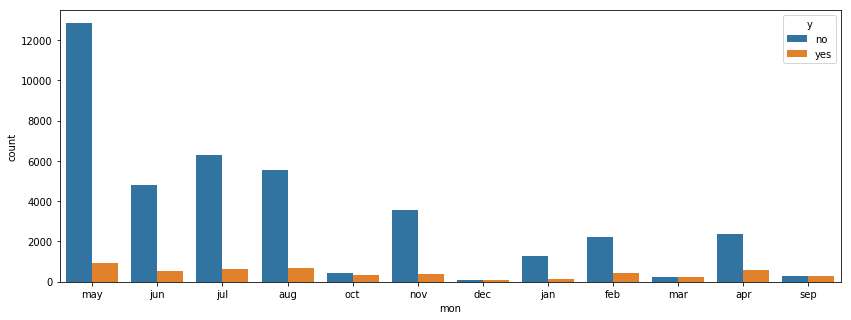

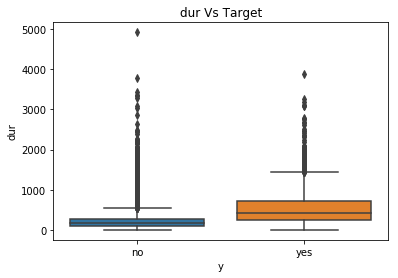

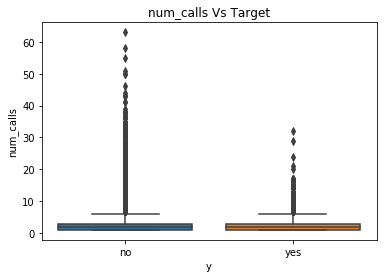

In [45]:
for i in range(9):
    plt.figure()
    if columns[i] in num_col:
        sns.boxplot(df['y'], df[columns[i]])
        plt.title(f'{columns[i]} Vs Target')
    else:
        if columns[i]=='job'or columns[i]=='mon':
            plt.figure(figsize=(14,5))
        sns.countplot(x=columns[i], data=df, hue='y')

**Observation:**<br>
- The ages between 25 and 45 are highly distributed.
- The age group between 30 to 50 are highly targeted and the subscribtion to insurance is highly distributed in that range.<br>
- Those who have blue-collar, management and technician jobs are highly targeted and whose job is management is more likely to subscribe to the insurance.<br>
- Those who are married have a high chance to subscribe than the one who are single, and who are less likely to subscribe are divorced.<br>
- Those who have educational qualfication as teritary and secondary are more likely to subscribe to the insurance. One with secondary education are targeted high.<br>
- The cellular type calls are more than telephone calls<br>
- The more number of calls are made in the middle of the month between day 10 to 20. The acceptance distribution is also high in that days.<br>
- The high number of calls are made in the months may, june and july. The calls between the months april to august have a high chance to subscribe to the insurance.<br>
- If the duration of the calls is moderate, they are more likely to subscribe.<br>
- When the number of calls are so high, the subscribtion is less likely to happen.

### age vs other features

In [46]:
col_age = columns
col_age.remove('age')
col_age.remove('y')
print(col_age)

['job', 'marital', 'education_qual', 'call_type', 'day', 'mon', 'dur', 'num_calls']


<Figure size 432x288 with 0 Axes>

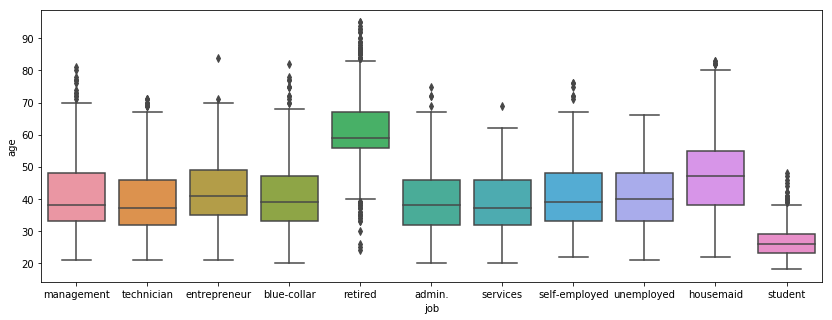

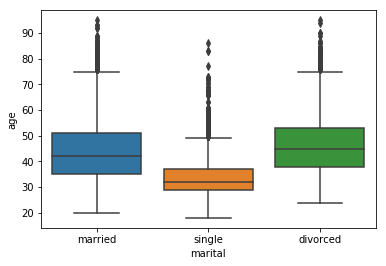

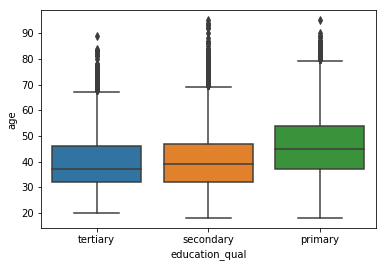

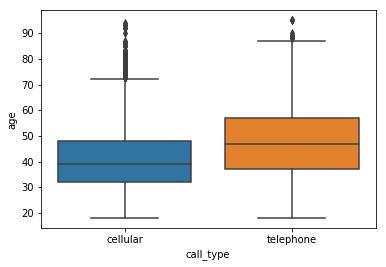

<Figure size 432x288 with 0 Axes>

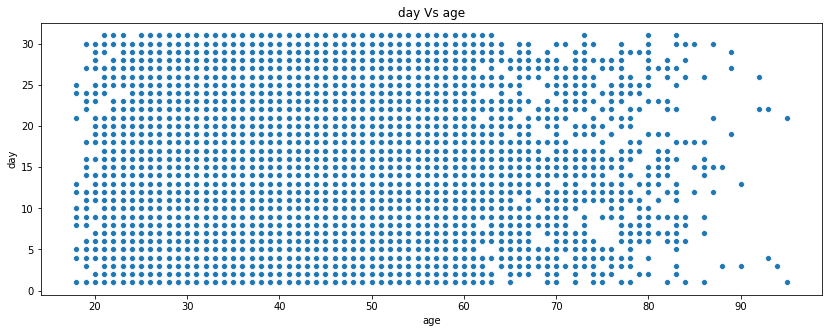

<Figure size 432x288 with 0 Axes>

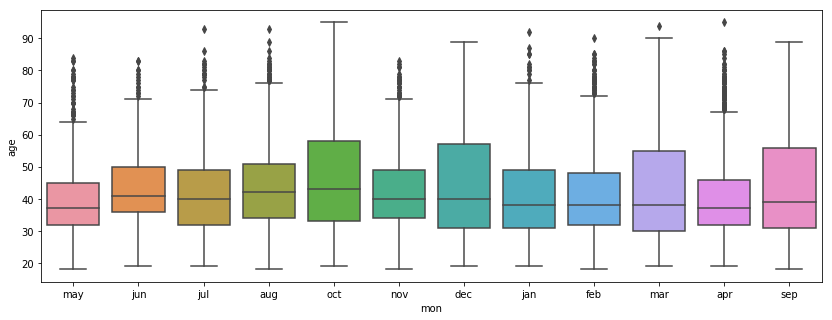

<Figure size 432x288 with 0 Axes>

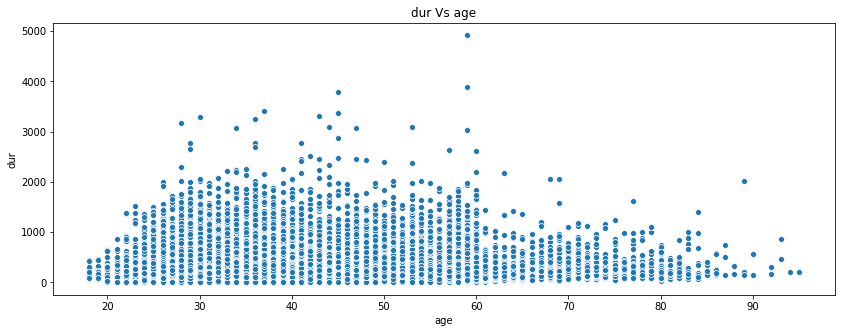

<Figure size 432x288 with 0 Axes>

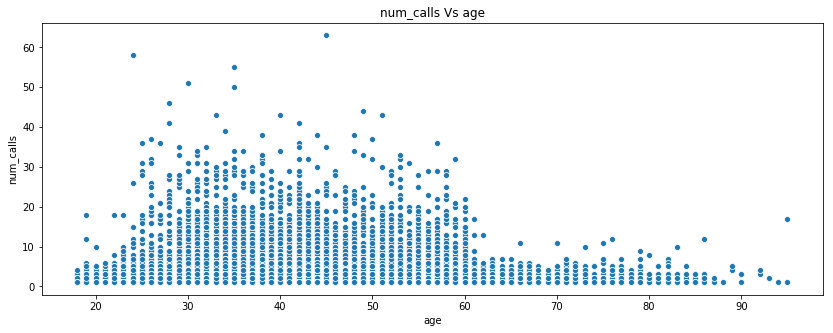

In [47]:
for i in col_age:
    plt.figure()
    if i in num_col:
        plt.figure(figsize=(14,5))
        sns.scatterplot(df['age'], df[i])
        plt.title(f'{i} Vs age')
    else:
        if i=='job'or i=='mon':
            plt.figure(figsize=(14,5))
        sns.boxplot(df[i], df['age'])

**Observation:**<br>
- As we know, the retried age is mostly high and students age is mostly less. All other job roles are more or less in the in same age group.
- Singles age is mostly less, the married and divorsed age is mostly high.
- Those who are having primary education age is mostly high compared to the other two education groups.
- The telephone calls are made mostly to those whose age is high.
- The duration of the calls is high between the age 40 to 60. And the duration of the call is so low, if the age is above 60.
- The number of calls is more between the age group of 25 to 55. And calls is less above the age of 60.

### job vs other features

In [48]:
col_job = col_age
col_job.remove('job')
print(col_job)

['marital', 'education_qual', 'call_type', 'day', 'mon', 'dur', 'num_calls']


<Figure size 432x288 with 0 Axes>

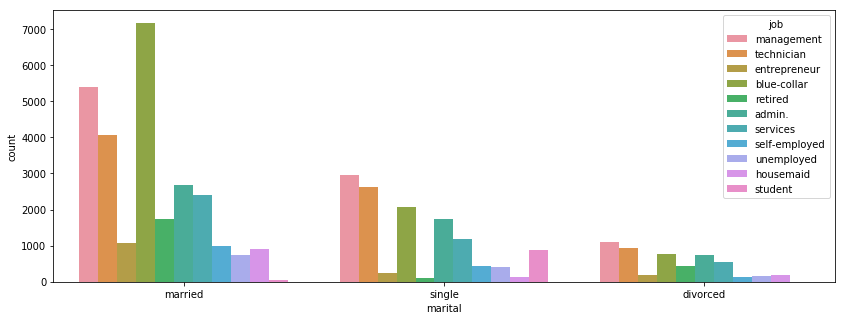

<Figure size 432x288 with 0 Axes>

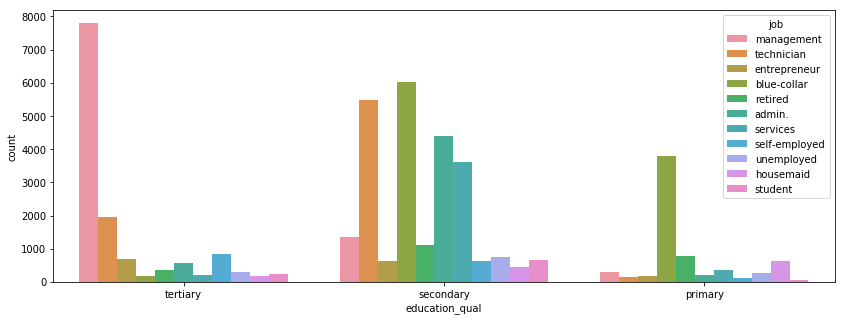

<Figure size 432x288 with 0 Axes>

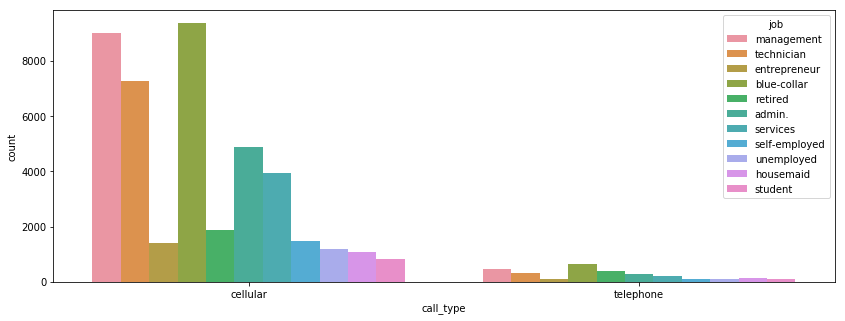

<Figure size 432x288 with 0 Axes>

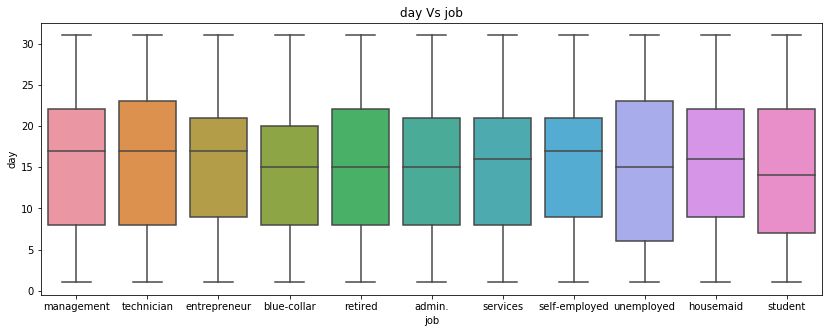

<Figure size 432x288 with 0 Axes>

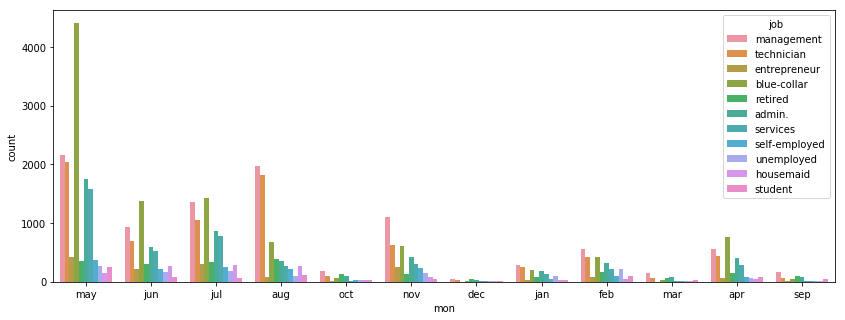

<Figure size 432x288 with 0 Axes>

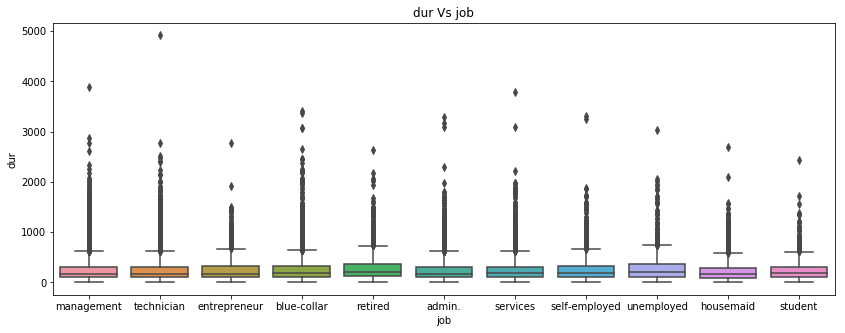

<Figure size 432x288 with 0 Axes>

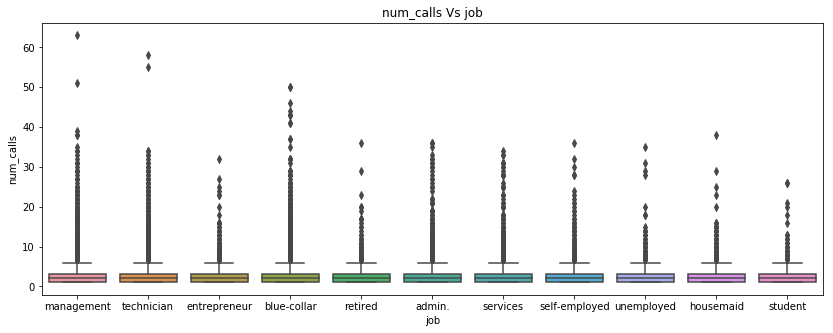

In [49]:
for i in col_age:
    plt.figure()
    if i in num_col:
        plt.figure(figsize=(14,5))
        sns.boxplot(df['job'], df[i])
        plt.title(f'{i} Vs job')
    else:
        plt.figure(figsize=(14,5))
        sns.countplot(x=i, data=df, hue='job')

**Observation:**<br>
- Those who are married and have and blue-collar and management jobs are targeted higher to sell an insurace.
- Those who have tertiary education and blue-collar job are more likely targeted to sell an insurance.
- In the month of may, the most calls are made, especially the one who have blue-collar jobs.

### marital vs other features

In [50]:
col_marital = col_job
col_marital.remove('marital')
print(col_marital)

['education_qual', 'call_type', 'day', 'mon', 'dur', 'num_calls']


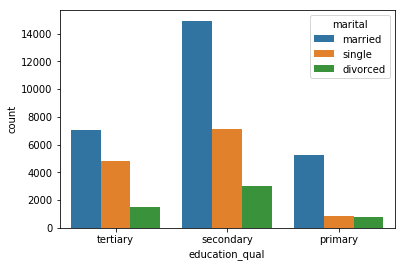

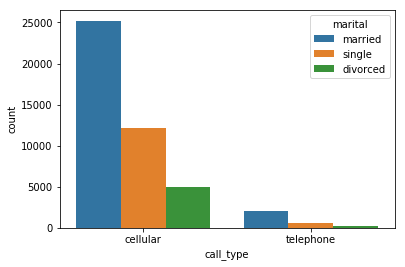

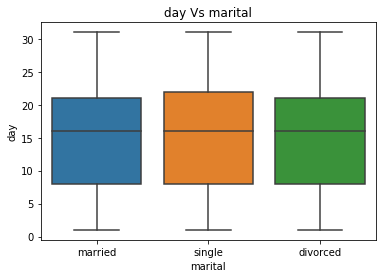

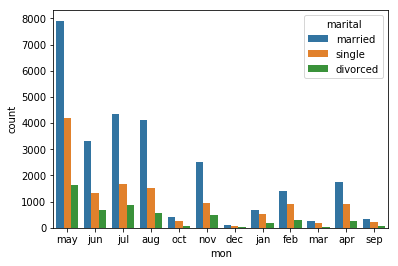

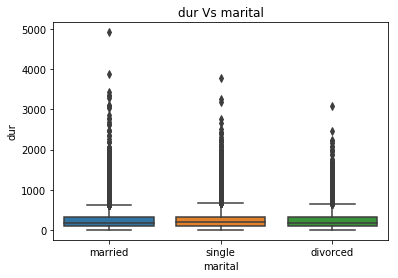

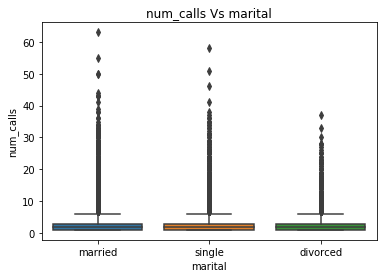

In [51]:
for i in col_age:
    plt.figure()
    if i in num_col:
        sns.boxplot(df['marital'], df[i])
        plt.title(f'{i} Vs marital')
    else:
        sns.countplot(x=i, data=df, hue='marital')

**Observation:**<br>
- Married are targeted more irrespective of what thier education.
- Married are targeted more irrespective of what the month.

### education_qual vs other features

In [52]:
col_education_qual = col_marital
col_education_qual.remove('education_qual')
print(col_education_qual)

['call_type', 'day', 'mon', 'dur', 'num_calls']


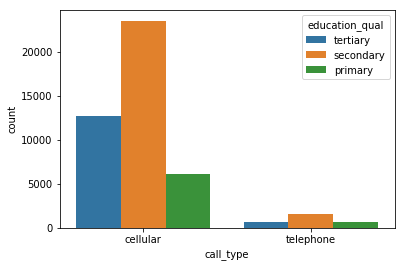

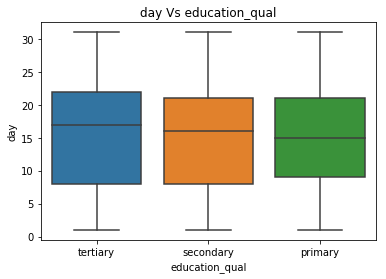

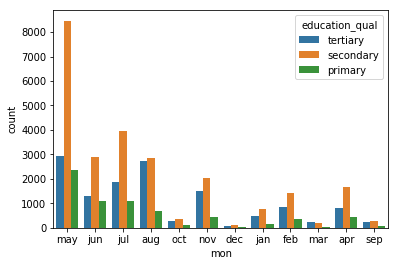

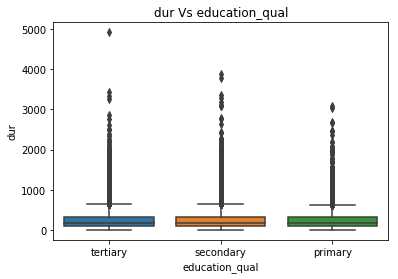

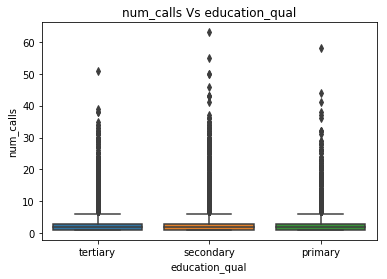

In [53]:
for i in col_age:
    plt.figure()
    if i in num_col:
        sns.boxplot(df['education_qual'], df[i])
        plt.title(f'{i} Vs education_qual')
    else:
        sns.countplot(x=i, data=df, hue='education_qual')

**Observation:**
- Irrespective of the month, those who are secondary education are targeted high to sell the insurance.

In [54]:
col_call_type = col_education_qual
col_call_type.remove('call_type')
print(col_call_type)

['day', 'mon', 'dur', 'num_calls']


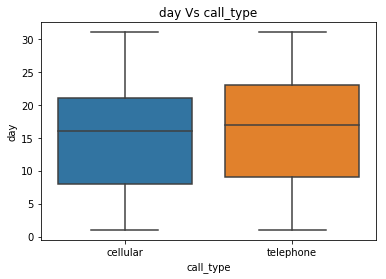

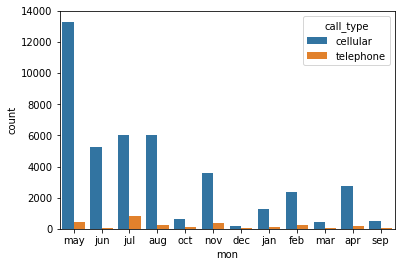

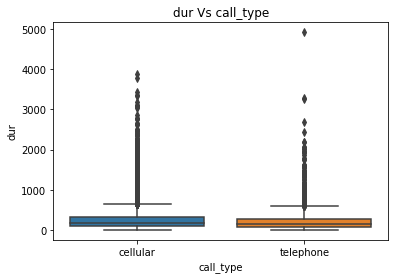

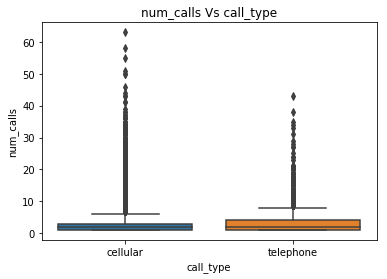

In [55]:
for i in col_age:
    plt.figure()
    if i in num_col:
        sns.boxplot(df['call_type'], df[i])
        plt.title(f'{i} Vs call_type')
    else:
        sns.countplot(x=i, data=df, hue='call_type')

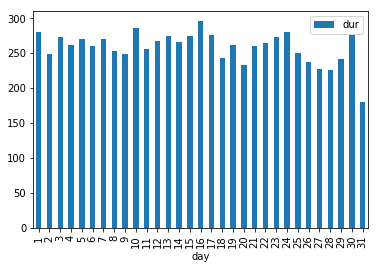

In [56]:
# day vs dur
df[['day', 'dur']].groupby('day').mean().plot(kind='bar')

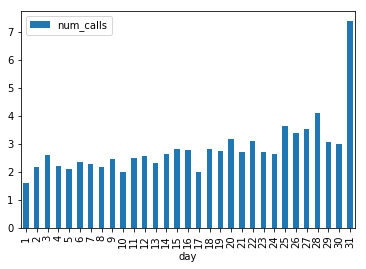

In [57]:
# day vs num_calls
df[['day', 'num_calls']].groupby('day').mean().plot(kind='bar')

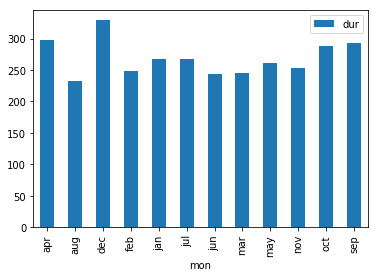

In [58]:
# mon vs dur
df[['mon', 'dur']].groupby('mon').mean().plot(kind='bar')

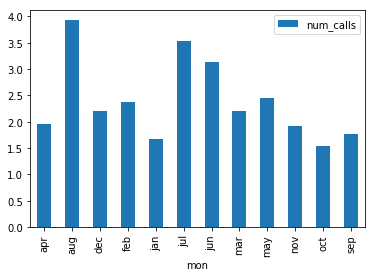

In [59]:
# mon vs num_calls
df[['mon', 'num_calls']].groupby('mon').mean().plot(kind='bar')

**Observation:**
- Number of calls are higher in the 31st day of the month.
- Number of calls are higher in the months june, july and august.

In [60]:
df.head()

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,y
0,58,management,married,tertiary,cellular,5,may,261,1,no
1,44,technician,single,secondary,cellular,5,may,151,1,no
2,33,entrepreneur,married,secondary,cellular,5,may,76,1,no
3,47,blue-collar,married,secondary,cellular,5,may,92,1,no
4,33,blue-collar,single,secondary,cellular,5,may,198,1,no


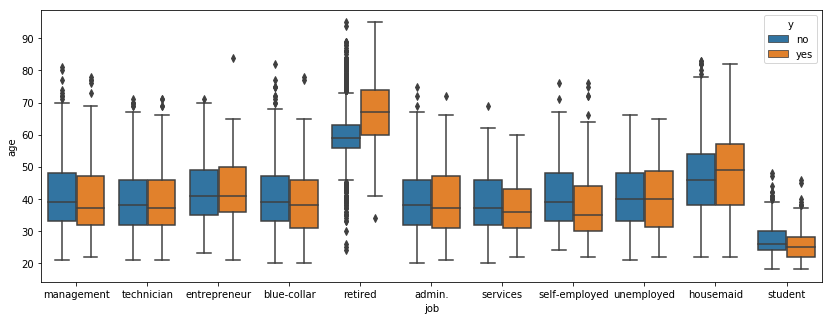

In [61]:
plt.figure(figsize=(14, 5))
sns.boxplot(df['job'], df['age'], hue=df['y'])

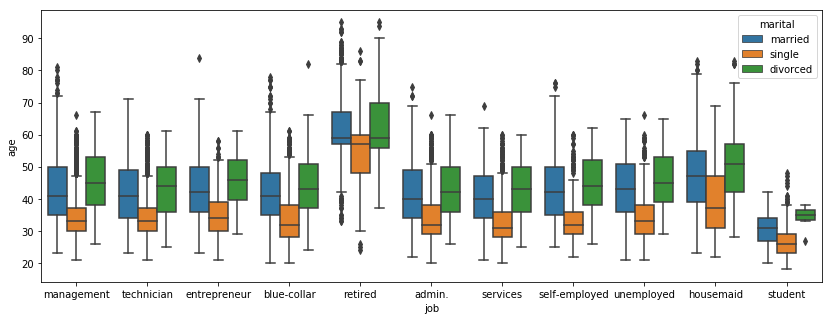

In [62]:
plt.figure(figsize=(14, 5))
sns.boxplot(df['job'], df['age'], hue=df['marital'])

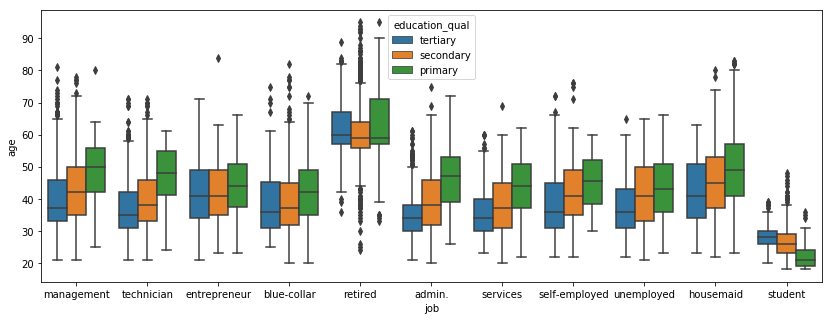

In [63]:
plt.figure(figsize=(14, 5))
sns.boxplot(df['job'], df['age'], hue=df['education_qual'])

## Encoding

In [64]:
df.head()

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,y
0,58,management,married,tertiary,cellular,5,may,261,1,no
1,44,technician,single,secondary,cellular,5,may,151,1,no
2,33,entrepreneur,married,secondary,cellular,5,may,76,1,no
3,47,blue-collar,married,secondary,cellular,5,may,92,1,no
4,33,blue-collar,single,secondary,cellular,5,may,198,1,no


### y Column Encoding

In [65]:
df.y.unique()

array(['no', 'yes'], dtype=object)

In [66]:
df['y'] = df['y'].map({'yes':1, 'no':0})

In [67]:
df['y']

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: y, Length: 45205, dtype: int64

### age Column Encoding

The age column is a continuous value and in the right encoding.

### job Column Encoding

In [68]:
df.job.unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'retired', 'admin.', 'services', 'self-employed', 'unemployed',
       'housemaid', 'student'], dtype=object)

Considering the job column as an ordinal data because the insurance acceptance correlates with the job of the person.

#### Doing an target guided ordinal encoding to job Column

In [69]:
## Aggregating to find the order of the job that got more no. of insurance
df['job'][df['y']==1].value_counts()

management       1301
technician        840
blue-collar       742
admin.            631
retired           516
services          369
student           269
unemployed        202
self-employed     187
entrepreneur      123
housemaid         109
Name: job, dtype: int64

In [70]:
job_cat_ord = {'housemaid':1, 'entrepreneur':2, 'self-employed':3, 'unemployed':4, 'student': 5, 'services':6,
              'retired':7, 'admin.':8, 'blue-collar':9, 'technician':10, 'management':11}
df['job'] = df['job'].map(job_cat_ord)

In [132]:
job_keys = job_cat_ord.keys()
print(sorted(list(job_keys)))

['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed']


In [71]:
# Checking if any spelling mistake when doing encoding
df['job'].unique()

array([11, 10,  2,  9,  7,  8,  6,  3,  4,  1,  5], dtype=int64)

### marital Column Encoding

In [72]:
df['marital'].unique()

array(['married', 'single', 'divorced'], dtype=object)

#### Doing an ordinal encoding

In [73]:
marital_cat_ord = {'divorced':1, 'single':2, 'married':3}
df['marital'] = df['marital'].map(marital_cat_ord)

### education_qual Column Encoding

In [74]:
df['education_qual'].unique()

array(['tertiary', 'secondary', 'primary'], dtype=object)

#### Doing an ordinal encoding

In [75]:
education_qual_cat_ord = {'primary':1, 'secondary':2, 'tertiary':3}
df['education_qual'] = df['education_qual'].map(education_qual_cat_ord)

In [76]:
df['education_qual'].unique()

array([3, 2, 1], dtype=int64)

### call_type Column Encoding

In [77]:
df['call_type'].unique()

array(['cellular', 'telephone'], dtype=object)

In [78]:
call_type_cat_ord = {'telephone':0, 'cellular':1}
df['call_type'] = df['call_type'].map(call_type_cat_ord)

In [79]:
df['call_type'].unique()

array([1, 0], dtype=int64)

### mon Column Encoding

In [80]:
df['mon'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

In [81]:
## Aggregating to find the order of the mon that got more no. of insurance
df['mon'][df['y']==1].value_counts()

may    925
aug    688
jul    627
apr    577
jun    546
feb    441
nov    403
oct    323
sep    269
mar    248
jan    142
dec    100
Name: mon, dtype: int64

#### Doing an target guided ordinal encoding to mon Column as the insurance acceptance correlates with what month the insurance call is made.

In [82]:
mon_cat_ord = {'dec':1, 'jan':2, 'mar':3, 'sep':4, 'oct':5, 'nov':6, 'feb':7, 'jun':8, 'apr':9, 'jul':10, 'aug':11, 'may':12}
df['mon'] = df['mon'].map(mon_cat_ord)

In [83]:
df['mon'].unique()

array([12,  8, 10, 11,  5,  6,  1,  2,  7,  3,  9,  4], dtype=int64)

In [84]:
df

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,y
0,58,11,3,3,1,5,12,261,1,0
1,44,10,2,2,1,5,12,151,1,0
2,33,2,3,2,1,5,12,76,1,0
3,47,9,3,2,1,5,12,92,1,0
4,33,9,2,2,1,5,12,198,1,0
...,...,...,...,...,...,...,...,...,...,...
45206,51,10,3,3,1,17,6,977,3,1
45207,71,7,1,1,1,17,6,456,2,1
45208,72,7,3,2,1,17,6,1127,5,1
45209,57,9,3,2,0,17,6,508,4,0


## Feature Selection

In [85]:
dt = DecisionTreeClassifier()
dt.fit(df.drop('y', axis=1), df['y'])

DecisionTreeClassifier()

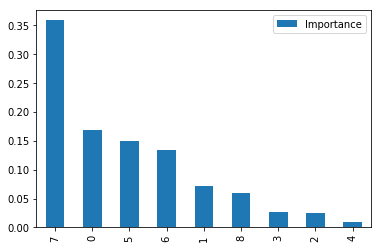

In [86]:
imp_fea = dt.feature_importances_
imp_df = pd.DataFrame({'Features': pd.DataFrame(df.drop('y', axis=1)).columns, 'Importance':imp_fea})
imp_df.set_index('Importance')
imp_df = imp_df.sort_values('Importance', ascending=False)
imp_df.plot.bar()

In [87]:
df.head()

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,y
0,58,11,3,3,1,5,12,261,1,0
1,44,10,2,2,1,5,12,151,1,0
2,33,2,3,2,1,5,12,76,1,0
3,47,9,3,2,1,5,12,92,1,0
4,33,9,2,2,1,5,12,198,1,0


In [88]:
df.drop(['marital', 'education_qual', 'call_type'], axis=1, inplace=True)

In [89]:
df.head()

,age,job,day,mon,dur,num_calls,y
0,58,11,5,12,261,1,0
1,44,10,5,12,151,1,0
2,33,2,5,12,76,1,0
3,47,9,5,12,92,1,0
4,33,9,5,12,198,1,0


## Splitting

In [90]:
X = df.drop('y', axis=1).values
y = df['y']

In [91]:
X

array([[  58,   11,    5,   12,  261,    1],
       [  44,   10,    5,   12,  151,    1],
       [  33,    2,    5,   12,   76,    1],
       ...,
       [  72,    7,   17,    6, 1127,    5],
       [  57,    9,   17,    6,  508,    4],
       [  37,    2,   17,    6,  361,    2]], dtype=int64)

In [92]:
y

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: y, Length: 45205, dtype: int64

In [93]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.25)

In [94]:
print(y_train.value_counts()[0]/len(y_train))
print(y_train.value_counts()[1]/len(y_train))

0.8829897059257293
0.11701029407427072


In [95]:
print(y_test.value_counts()[0]/len(y_test))
print(y_test.value_counts()[1]/len(y_test))

0.8830295522916298
0.1169704477083702


## Balancing of Data

In [96]:
from imblearn.combine import SMOTEENN
smt = SMOTEENN(sampling_strategy='all')
X_smt, y_smt = smt.fit_resample(X_train, y_train)

In [97]:
X_smt

array([[ 32,   9,   8,  12, 134,   1],
       [ 46,  10,  11,  11, 138,   3],
       [ 36,  10,  28,  11, 171,   1],
       ...,
       [ 50,   1,   4,   7, 700,   1],
       [ 35,  11,  22,   5, 155,   1],
       [ 58,   8,   9,   7, 270,   2]], dtype=int64)

In [98]:
y_smt = y_smt.values

In [99]:
y_smt

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [100]:
X_smt = pd.DataFrame(X_smt)

In [101]:
X_smt.shape

(49580, 6)

In [102]:
pd.DataFrame(y_smt).value_counts()

1    27659
0    21921
dtype: int64

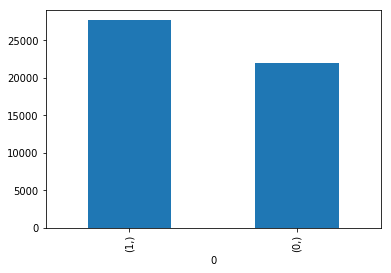

In [103]:
pd.DataFrame(y_smt).value_counts().plot(kind='bar')

In [104]:
X_smt.describe()

,0,1,2,3,4,5
count,49580.000000,49580.000000,49580.000000,49580.000000,49580.000000,49580.000000
mean,41.115510,8.113130,15.402703,8.788927,378.158552,2.356999
std,11.680787,2.490226,8.139042,2.792328,361.387876,2.649378
min,18.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,32.000000,7.000000,8.000000,7.000000,135.000000,1.000000
50%,39.000000,9.000000,15.000000,9.000000,252.000000,2.000000
75%,49.000000,10.000000,21.000000,11.000000,505.000000,3.000000
max,95.000000,11.000000,31.000000,12.000000,3366.000000,63.000000


## Outlier Detection

### age Column

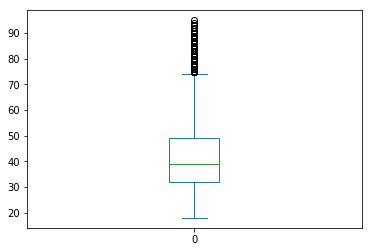

In [105]:
X_smt.iloc[:, 0].plot(kind='box')

In [106]:
iqr = X_smt[X_smt.columns[0]].quantile(0.75) - X_smt[X_smt.columns[0]].quantile(0.25)
upper_threshold = X_smt[X_smt.columns[0]].quantile(0.75) + (1.5 * iqr)
lower_threshold = X_smt[X_smt.columns[0]].quantile(0.25) - (1.5 * iqr)
print(lower_threshold)
print(upper_threshold)

6.5
74.5


The outliers are there in age column as maximum age is 95 and should be treated.

In [107]:
X_smt[0].clip(lower_threshold, upper_threshold, inplace=True)

In [108]:
X_smt[0].max()

74.5

In [109]:
X_smt = X_smt.values

In [110]:
X_smt

array([[ 32.,   9.,   8.,  12., 134.,   1.],
       [ 46.,  10.,  11.,  11., 138.,   3.],
       [ 36.,  10.,  28.,  11., 171.,   1.],
       ...,
       [ 50.,   1.,   4.,   7., 700.,   1.],
       [ 35.,  11.,  22.,   5., 155.,   1.],
       [ 58.,   8.,   9.,   7., 270.,   2.]])

## Scaling

In [111]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_smt = sc.fit_transform(X_smt)
X_test = sc.transform(X_test)

In [112]:
X_smt

array([[-0.78704804,  0.3561439 , -0.90953913,  1.14997441, -0.67562038,
        -0.51220039],
       [ 0.42851533,  0.757718  , -0.54094168,  0.79184664, -0.66455183,
         0.24270137],
       [-0.43974422,  0.757718  ,  1.54777726,  0.79184664, -0.57323628,
        -0.51220039],
       ...,
       [ 0.77581915, -2.85644889, -1.40100241, -0.64066443,  0.89057967,
        -0.51220039],
       [-0.52657017,  1.1592921 ,  0.81058234, -1.35691997, -0.61751048,
        -0.51220039],
       [ 1.47042679, -0.0454302 , -0.78667331, -0.64066443, -0.29928963,
        -0.13474951]])

In [113]:
X_test

array([[ 1.03629702, -0.84857839,  0.19625324,  0.07559111, -0.43487938,
        -0.13474951],
       [-0.96069995, -1.65172659, -1.64673405, -0.28253666, -0.55386631,
        -0.13474951],
       [-0.35291826,  0.757718  ,  1.42491144,  1.14997441, -0.11942566,
         0.24270137],
       ...,
       [ 1.47042679,  0.3561439 ,  1.67064308, -0.28253666, -0.23011118,
        -0.51220039],
       [ 0.34168938, -0.0454302 , -1.27813659,  1.14997441, -0.20520694,
        -0.13474951],
       [-0.78704804, -2.85644889,  0.68771652,  0.79184664,  1.10088215,
        -0.13474951]])

## Model

### Logistic Regression

In [113]:
lr = LogisticRegression()
lr.fit(X_smt, y_smt)

LogisticRegression()

In [114]:
print(confusion_matrix(y_test, lr.predict(X_test)))

[[7170 2810]
 [ 264 1058]]


In [115]:
roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])

0.841937505874078

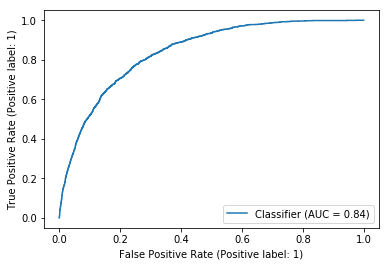

In [116]:
RocCurveDisplay.from_predictions(y_test, lr.predict_proba(X_test)[:, 1])

In [117]:
print(classification_report(lr.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.72      0.96      0.82      7434
           1       0.80      0.27      0.41      3868

    accuracy                           0.73     11302
   macro avg       0.76      0.62      0.62     11302
weighted avg       0.75      0.73      0.68     11302



### K - Nearest Neighbors

In [118]:
knn = KNeighborsClassifier()
k_range = range(1, 21)
train_scores = []
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_smt, y_smt)
    train_score = roc_auc_score(y_smt, knn.predict_proba(X_smt)[:, 1])
    val_score = np.mean(cross_val_score(knn, X_smt, y_smt, cv=5, scoring='roc_auc'))
    k_score = val_score
    print(f'K = {k}----Train Score = {train_score}----CV Score = {k_score}')

K = 1----Train Score = 1.0----CV Score = 0.9278124451845435
K = 2----Train Score = 0.9980856312657597----CV Score = 0.9529618012060054
K = 3----Train Score = 0.9961921775318818----CV Score = 0.9623910974691675
K = 4----Train Score = 0.994613915517961----CV Score = 0.9671111507959095
K = 5----Train Score = 0.99320448670477----CV Score = 0.9698426495755965
K = 6----Train Score = 0.991927351888595----CV Score = 0.9716855553229322
K = 7----Train Score = 0.9908221721256071----CV Score = 0.9727764053417334
K = 8----Train Score = 0.9898324718514657----CV Score = 0.9733801321227276
K = 9----Train Score = 0.9889515051754719----CV Score = 0.9738392911912686
K = 10----Train Score = 0.9881705597968036----CV Score = 0.9740522221224183
K = 11----Train Score = 0.9873682702771929----CV Score = 0.9741763146703452
K = 12----Train Score = 0.9866431936896274----CV Score = 0.9741446387874128
K = 13----Train Score = 0.9859211733798464----CV Score = 0.9740301216208984
K = 14----Train Score = 0.98521582646817

In [119]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_smt, y_smt)

KNeighborsClassifier(n_neighbors=9)

In [120]:
print(confusion_matrix(y_test, knn.predict(X_test)))

[[7916 2064]
 [ 266 1056]]


In [121]:
roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])

0.8635513841601509

In [122]:
print(classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      9980
           1       0.34      0.80      0.48      1322

    accuracy                           0.79     11302
   macro avg       0.65      0.80      0.67     11302
weighted avg       0.89      0.79      0.83     11302



### Decision Tree

In [123]:
dt = DecisionTreeClassifier()
for depth in [1,2,3,4,5,6,7,8,9,10,20,30,40]:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_smt, y_smt)
    train_score = roc_auc_score(y_smt, dt.predict(X_smt))
    dt = DecisionTreeClassifier(max_depth=depth)
    val_score = np.mean(cross_val_score(dt, X_smt, y_smt, cv=10, scoring='roc_auc'))
    print("Depth  : ", depth, " Training Accuracy : ", train_score, " Cross val score : " ,val_score)

Depth  :  1  Training Accuracy :  0.7780209092961964  Cross val score :  0.7777161915875299
Depth  :  2  Training Accuracy :  0.7780209092961964  Cross val score :  0.8669482624286509
Depth  :  3  Training Accuracy :  0.8254163088613702  Cross val score :  0.9093155132793729
Depth  :  4  Training Accuracy :  0.8460838079976771  Cross val score :  0.9275586273081962
Depth  :  5  Training Accuracy :  0.8445471759402269  Cross val score :  0.937860119703126
Depth  :  6  Training Accuracy :  0.8660882766377038  Cross val score :  0.9479185778559568
Depth  :  7  Training Accuracy :  0.8876576823521417  Cross val score :  0.956118541891208
Depth  :  8  Training Accuracy :  0.8987430276525639  Cross val score :  0.9604650845566498
Depth  :  9  Training Accuracy :  0.9111759316474314  Cross val score :  0.9627719459114651
Depth  :  10  Training Accuracy :  0.9194472743374305  Cross val score :  0.9636828662499178
Depth  :  20  Training Accuracy :  0.9959975519032335  Cross val score :  0.94617

In [124]:
dt = DecisionTreeClassifier(max_depth=9)
dt.fit(X_smt, y_smt)

DecisionTreeClassifier(max_depth=9)

In [125]:
print(confusion_matrix(y_test, dt.predict(X_test)))

[[7722 2258]
 [ 241 1081]]


In [126]:
roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])

0.861583037481923

In [127]:
print(classification_report(y_test, dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86      9980
           1       0.32      0.82      0.46      1322

    accuracy                           0.78     11302
   macro avg       0.65      0.80      0.66     11302
weighted avg       0.89      0.78      0.81     11302



### Voting Classifier

In [128]:
from sklearn.ensemble import VotingClassifier
vc = VotingClassifier(estimators=[('lr', lr), ('dt', dt),('knn', knn)], voting='soft')
vc.fit(X_smt, y_smt)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('dt', DecisionTreeClassifier(max_depth=9)),
                             ('knn', KNeighborsClassifier(n_neighbors=9))],
                 voting='soft')

In [129]:
print(confusion_matrix(y_test, vc.predict(X_test)))

[[7861 2119]
 [ 227 1095]]


In [130]:
roc_auc_score(y_test, vc.predict_proba(X_test)[:,1])

0.8814291214804798

In [131]:
print(classification_report(y_test, vc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      9980
           1       0.34      0.83      0.48      1322

    accuracy                           0.79     11302
   macro avg       0.66      0.81      0.68     11302
weighted avg       0.90      0.79      0.82     11302



### Random Forest

In [132]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [10, 100, 500],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4, 5]
}

from sklearn.model_selection import GridSearchCV
grid_rf_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = 8, verbose = 2)
grid_rf_search.fit(X_smt, y_smt)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=8,
             param_grid={'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [10, 100, 500]},
             verbose=2)

In [133]:
grid_rf_search.best_estimator_

RandomForestClassifier(min_samples_leaf=2, min_samples_split=3,
                       n_estimators=500)

In [144]:
for depth in range(30, 41):
    rf = RandomForestClassifier(max_depth=depth, n_estimators=500, min_samples_split=3, min_samples_leaf=2)
    rf.fit(X_smt, y_smt)
    train_score = roc_auc_score(y_smt, rf.predict(X_smt))
    rf = RandomForestClassifier(max_depth=depth)
    val_score = np.mean(cross_val_score(rf, X_smt, y_smt, cv=10, scoring='roc_auc'))
    print("Depth  : ", depth, " Training Accuracy : ", train_score, " Cross val score : " ,val_score)

Depth  :  30  Training Accuracy :  0.9896359644787277  Cross val score :  0.9931086991633142
Depth  :  31  Training Accuracy :  0.9894537465742297  Cross val score :  0.9931749186670048
Depth  :  32  Training Accuracy :  0.9895891607635848  Cross val score :  0.9930922319099723
Depth  :  33  Training Accuracy :  0.9894899902768863  Cross val score :  0.9931566838712935
Depth  :  34  Training Accuracy :  0.9894441859529582  Cross val score :  0.9931127835348657
Depth  :  35  Training Accuracy :  0.9898000605318974  Cross val score :  0.9930412777737858


KeyboardInterrupt: 

In [145]:
rf = RandomForestClassifier(max_depth=31, n_estimators=500, min_samples_split=3, min_samples_leaf=2)
rf.fit(X_smt, y_smt)

RandomForestClassifier(max_depth=31, min_samples_leaf=2, min_samples_split=3,
                       n_estimators=500)

In [146]:
print(confusion_matrix(y_test, rf.predict(X_test)))

[[8246 1734]
 [ 243 1079]]


In [147]:
print(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

0.8940620272314674


In [148]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.83      0.89      9980
           1       0.38      0.82      0.52      1322

    accuracy                           0.83     11302
   macro avg       0.68      0.82      0.71     11302
weighted avg       0.90      0.83      0.85     11302



### XG Boost

In [223]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.7]
}

#### Randomized Search

In [224]:
xgb = XGBClassifier()
random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=5, scoring='roc_auc', n_jobs=-1, cv=5, verbose=3)
random_search.fit(X_smt, y_smt)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=Non

In [225]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.6, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=7,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [226]:
random_search.best_params_

{'min_child_weight': 7,
 'max_depth': 8,
 'learning_rate': 0.6,
 'gamma': 0.4,
 'colsample_bytree': 0.7}

#### Bayes Search

In [259]:
xgb = XGBClassifier()
bayes_search = BayesSearchCV(xgb, search_spaces=param_grid, n_iter=5, scoring='roc_auc', n_jobs=-1, cv=10, verbose=3)
bayes_search.fit(X_smt, y_smt)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


BayesSearchCV(cv=10,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, gamma=None, gpu_id=None,
                                      grow_policy=None, importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None, max_bin=None,
                                      max_...
                                      n_estimators=100, n_jobs=None,
                                      num_parallel_tree=None, predictor=None,
                                      random_state=None, reg_alpha=None,
               

In [260]:
bayes_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.2, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.4, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [262]:
bayes_search.best_params_

OrderedDict([('colsample_bytree', 0.5),
             ('gamma', 0.2),
             ('learning_rate', 0.4),
             ('max_depth', 12),
             ('min_child_weight', 3)])

#### Grid Search

In [280]:
import time
start_time = time.time()
xgb = XGBClassifier()
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='roc_auc', n_jobs=-1, cv=5, verbose=3)
grid_search.fit(X_smt, y_smt)
end_time = time.time()

Fitting 5 folds for each of 6400 candidates, totalling 32000 fits


In [306]:
print((end_time-start_time)/60, 'minutes')

102.90837547779083 minutes


In [283]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [284]:
grid_search.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.0,
 'learning_rate': 0.2,
 'max_depth': 15,
 'min_child_weight': 1}

#### XGBoost Training

In [133]:
xgb = XGBClassifier(min_child_weight=1,
 max_depth=15,
 learning_rate=0.2,
 gamma=0.0,
 colsample_bytree=0.7)
xgb.fit(X_smt, y_smt)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [134]:
print(confusion_matrix(y_test, xgb.predict(X_test)))

[[8337 1643]
 [ 273 1049]]


In [135]:
roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])

0.8877794924190288

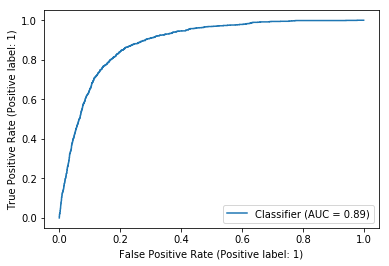

In [136]:
RocCurveDisplay.from_predictions(y_test, xgb.predict_proba(X_test)[:, 1])

In [137]:
print(classification_report(y_test, xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90      9980
           1       0.39      0.79      0.52      1322

    accuracy                           0.83     11302
   macro avg       0.68      0.81      0.71     11302
weighted avg       0.90      0.83      0.85     11302



## Pickling

In [115]:
import pickle

#### Pickling the model

In [ ]:
pickle.dump(xgb, open('CCP_XGBClassication.pkl', 'wb'))

In [124]:
pickled_model = pickle.load(open('CCP_XGBClassication.pkl', 'rb'))

In [128]:
pickled_model.predict([list(X_test[1])])

array([1])

#### Pickling the Scaler

In [116]:
pickle.dump(sc, open('scaler.pkl', 'wb'))